### Run basic `scanpy` QC and doublet detection with `scrublet` for merged `Kdm6aKO` dataset

- **Developed by**: Carlos Talavera-López PhD
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v240103

### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.10.2
scanpy      1.9.5
-----
PIL                 10.0.0
asttokens           NA
backcall            0.2.0
colorama            0.4.6
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
exceptiongroup      1.1.3
executing           1.2.0
h5py                3.9.0
igraph              0.10.8
importlib_resources NA
ipykernel           6.25.1
ipywidgets          8.1.0
jedi                0.19.0
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.1
llvmlite            0.40.1
louvain             0.8.1
matplotlib          3.7.2
mpl_toolkits        NA
natsort             8.4.0
numba               0.57.1
numexpr             2.8.7
numpy               1.24.4
packaging           23.1
pandas              2.1.1
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs    

In [3]:
path = '../data/'

### Read individual `anndata` objects and predict doublets per sample

In [5]:
adata = sc.read_h5ad(path + 'Kdm6aKO_KDM6A_GEX_ctl240101.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 2846264 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch'
    var: 'gene_ids', 'feature_types', 'modality'

In [6]:
sc.pp.filter_cells(adata, min_genes = 200)
print(adata.n_obs, adata.n_vars)

filtered out 2786331 cells that have less than 200 genes expressed
59933 32285


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.22
Detected doublet rate = 13.1%
Estimated detectable doublet fraction = 35.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 37.0%
Elapsed time: 16.3 seconds


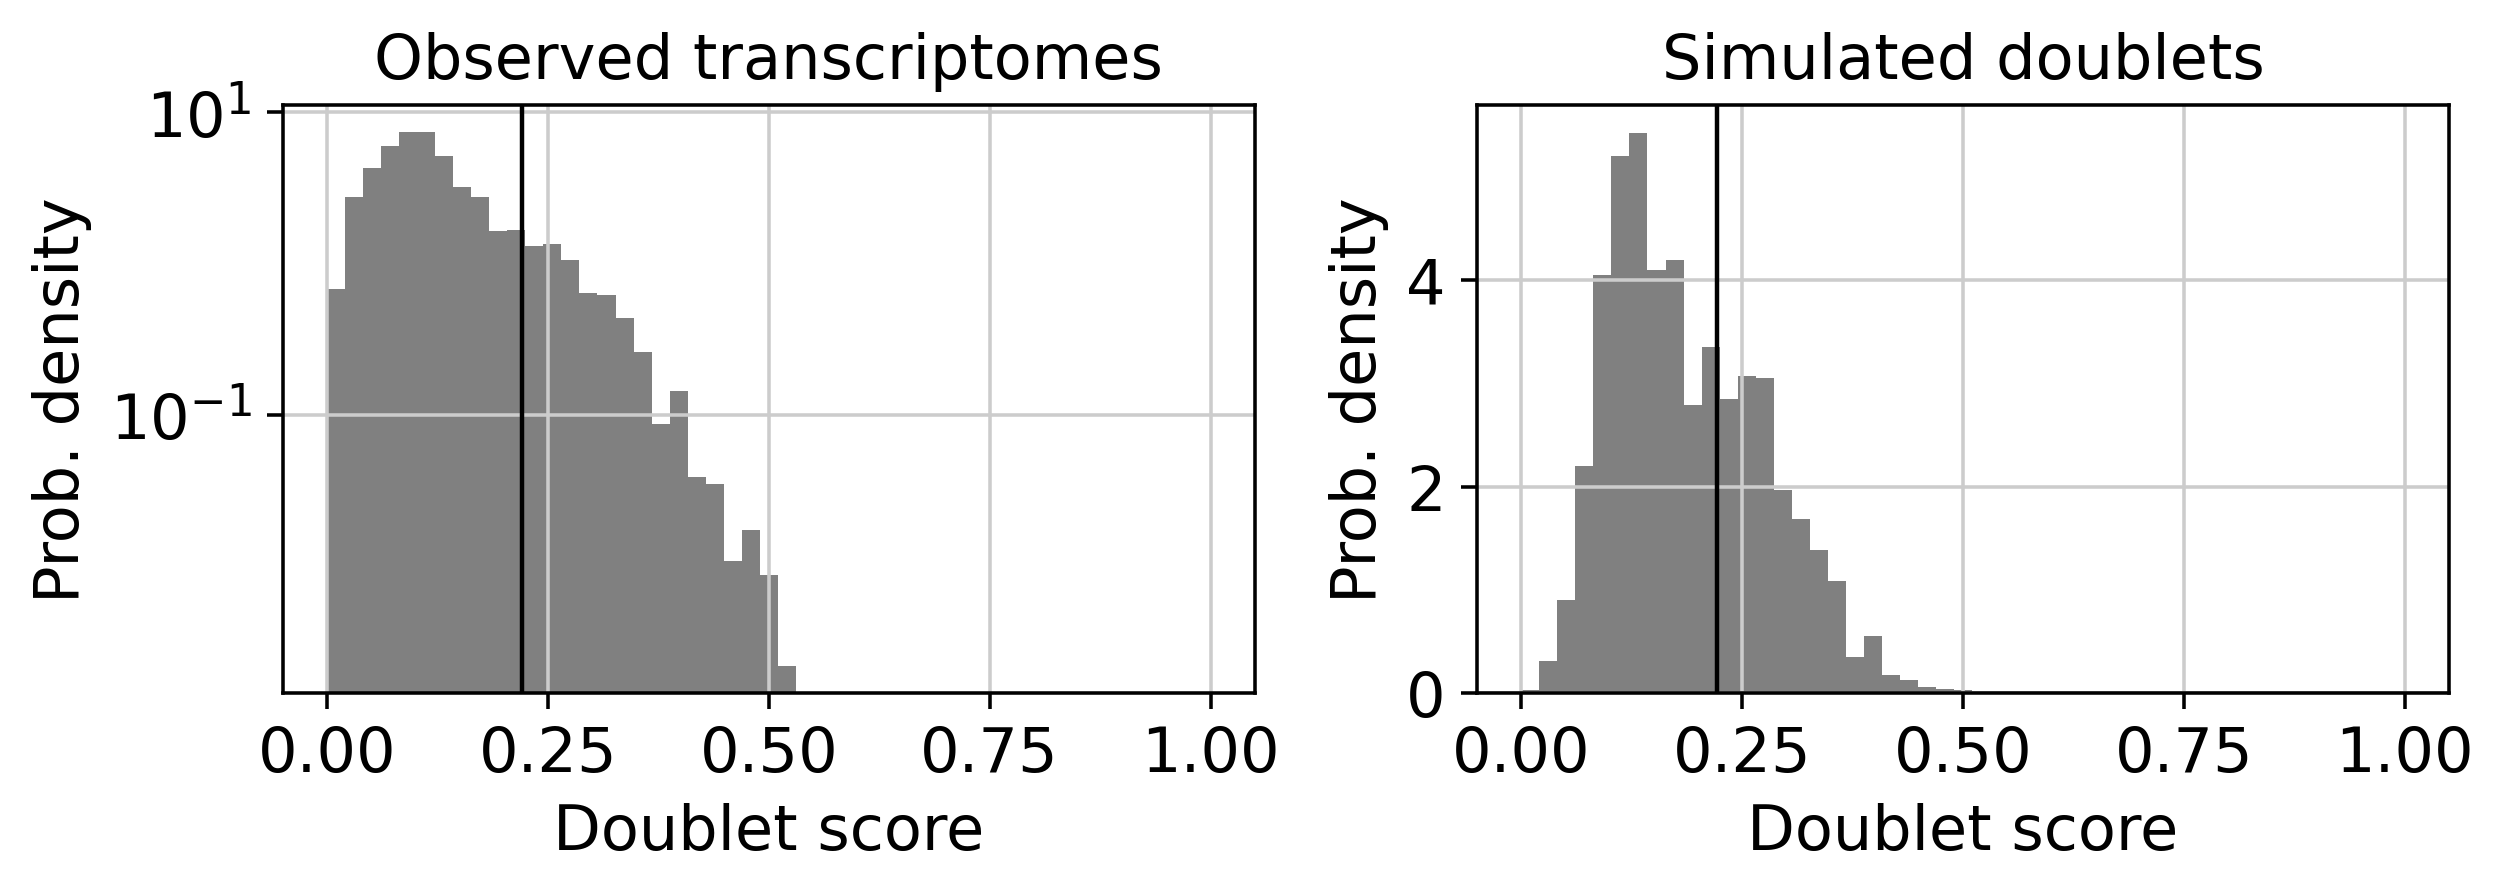

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 6.8%
Estimated detectable doublet fraction = 34.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 19.8%
Elapsed time: 3.8 seconds


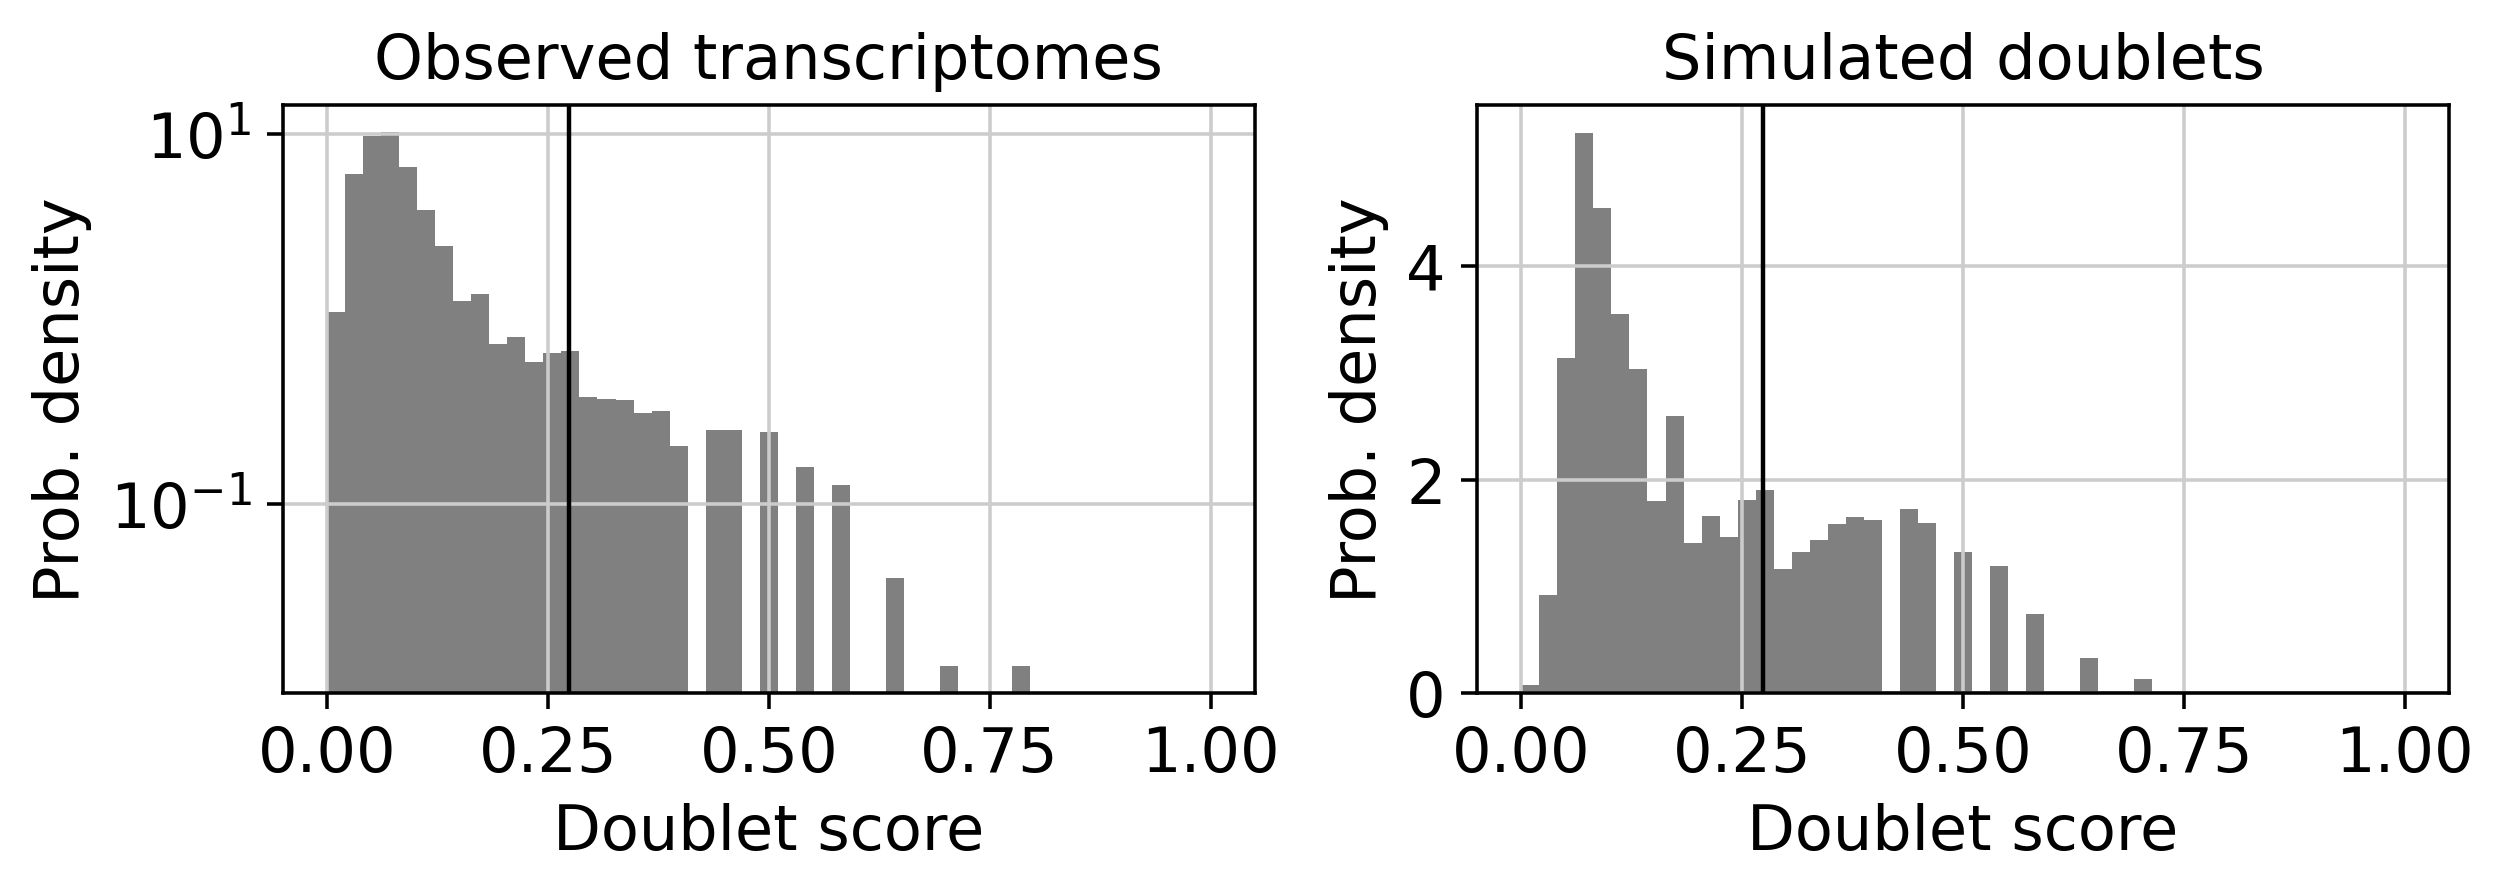

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 6.5 seconds


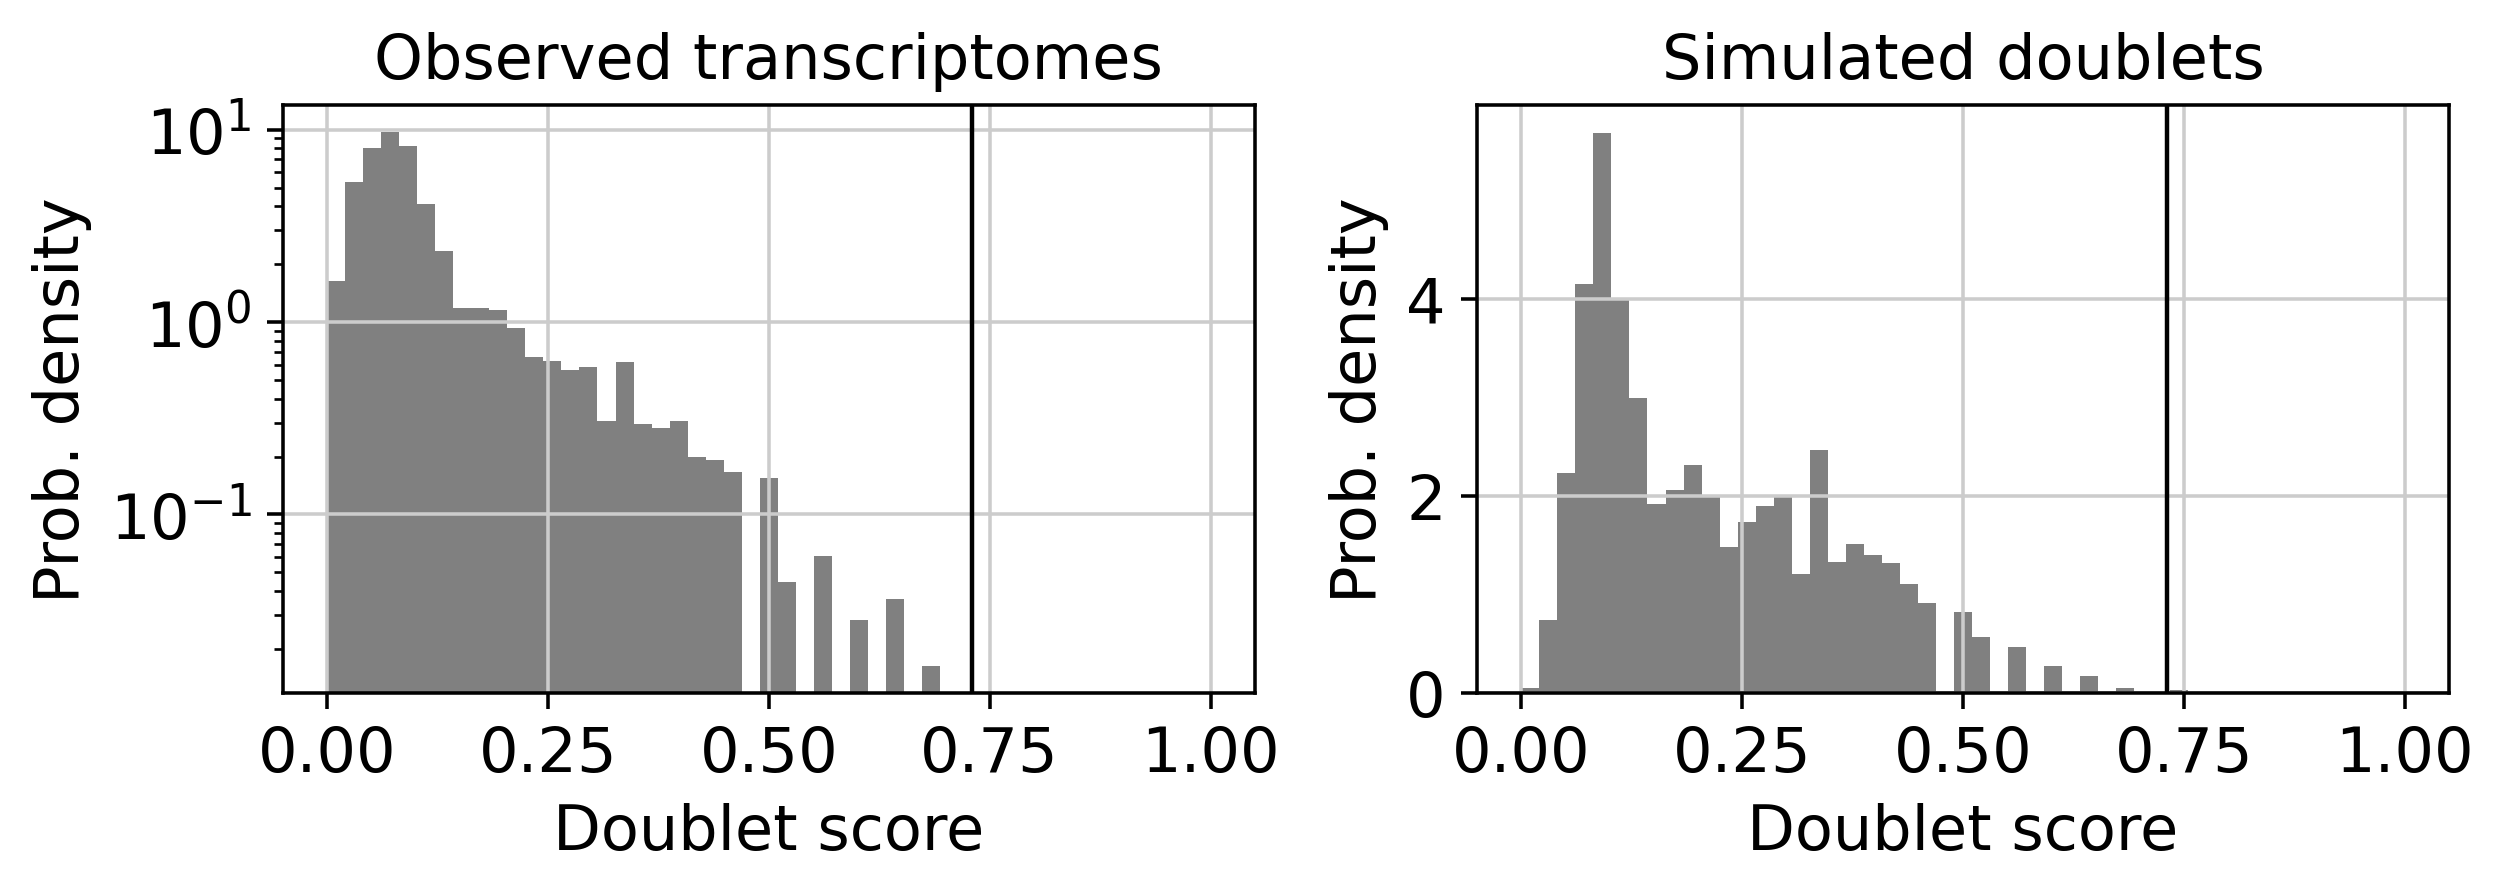

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.22
Detected doublet rate = 11.9%
Estimated detectable doublet fraction = 42.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 28.2%
Elapsed time: 11.0 seconds


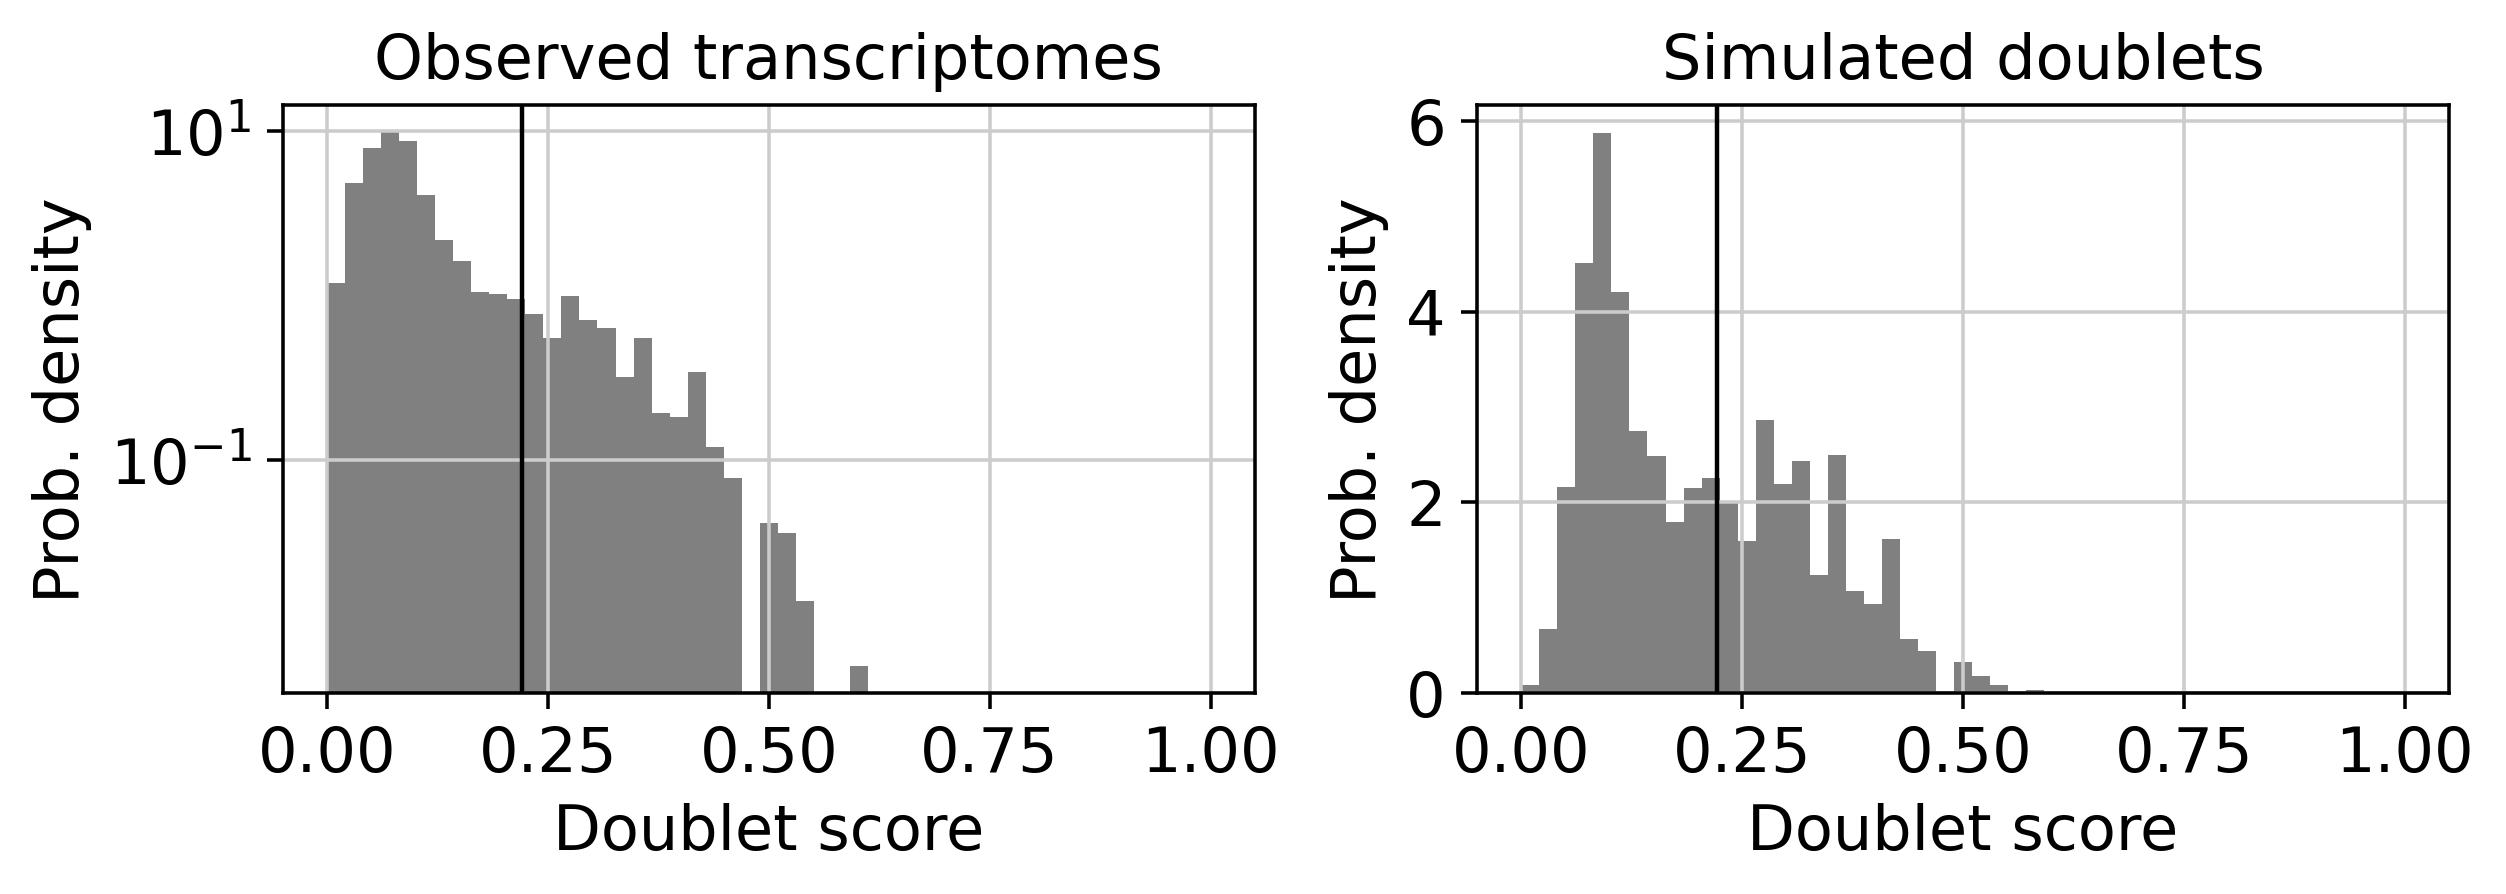

In [7]:
sample_names = adata.obs['sample'].unique()

for sample_name in sample_names:
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()

    scrub = scr.Scrublet(sample_adata.X)

    sample_adata.obs['doublet_scores'], sample_adata.obs['predicted_doublets'] = scrub.scrub_doublets()

    adata.obs.loc[mask, 'doublet_scores'] = sample_adata.obs['doublet_scores']
    adata.obs.loc[mask, 'predicted_doublets'] = sample_adata.obs['predicted_doublets']

    scrub.plot_histogram()

    plt.show()

In [8]:
adata

AnnData object with n_obs × n_vars = 59933 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'modality'

In [9]:
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 59933 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'modality'

In [10]:
sample_object.shape

(59933, 32285)

### Compute QC stats

In [11]:
sample_object.shape

(59933, 32285)

In [12]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('mt-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("Rps","Rpl"))
sample_object.var

,gene_ids,feature_types,modality,mt,ribo
Xkr4,ENSMUSG00000051951,Gene Expression,GEX,False,False
Gm1992,ENSMUSG00000089699,Gene Expression,GEX,False,False
Gm19938,ENSMUSG00000102331,Gene Expression,GEX,False,False
Gm37381,ENSMUSG00000102343,Gene Expression,GEX,False,False
Rp1,ENSMUSG00000025900,Gene Expression,GEX,False,False
...,...,...,...,...,...
AC124606.1,ENSMUSG00000095523,Gene Expression,GEX,False,False
AC133095.2,ENSMUSG00000095475,Gene Expression,GEX,False,False
AC133095.1,ENSMUSG00000094855,Gene Expression,GEX,False,False
AC234645.1,ENSMUSG00000095019,Gene Expression,GEX,False,False


In [13]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [14]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('mt-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1)

In [15]:
sample_object

AnnData object with n_obs × n_vars = 59933 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC covariates

In [16]:
sample_object.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

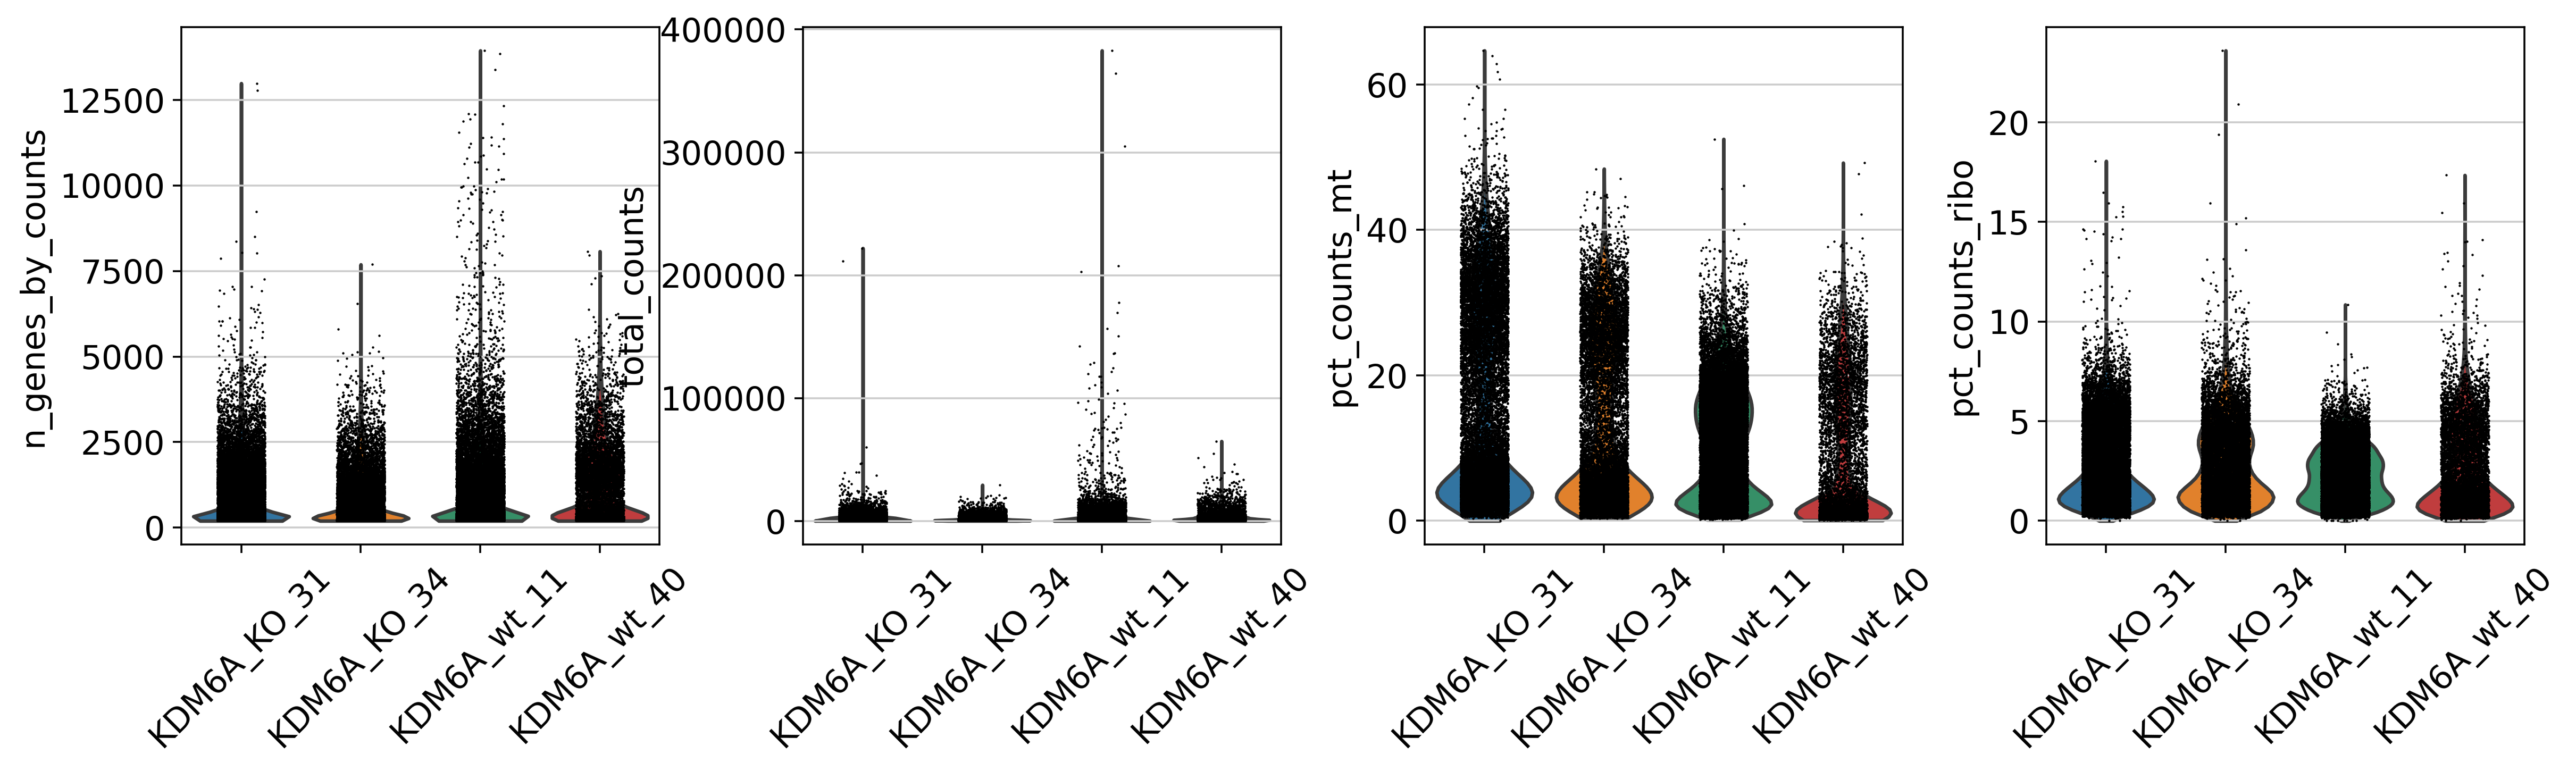

In [17]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


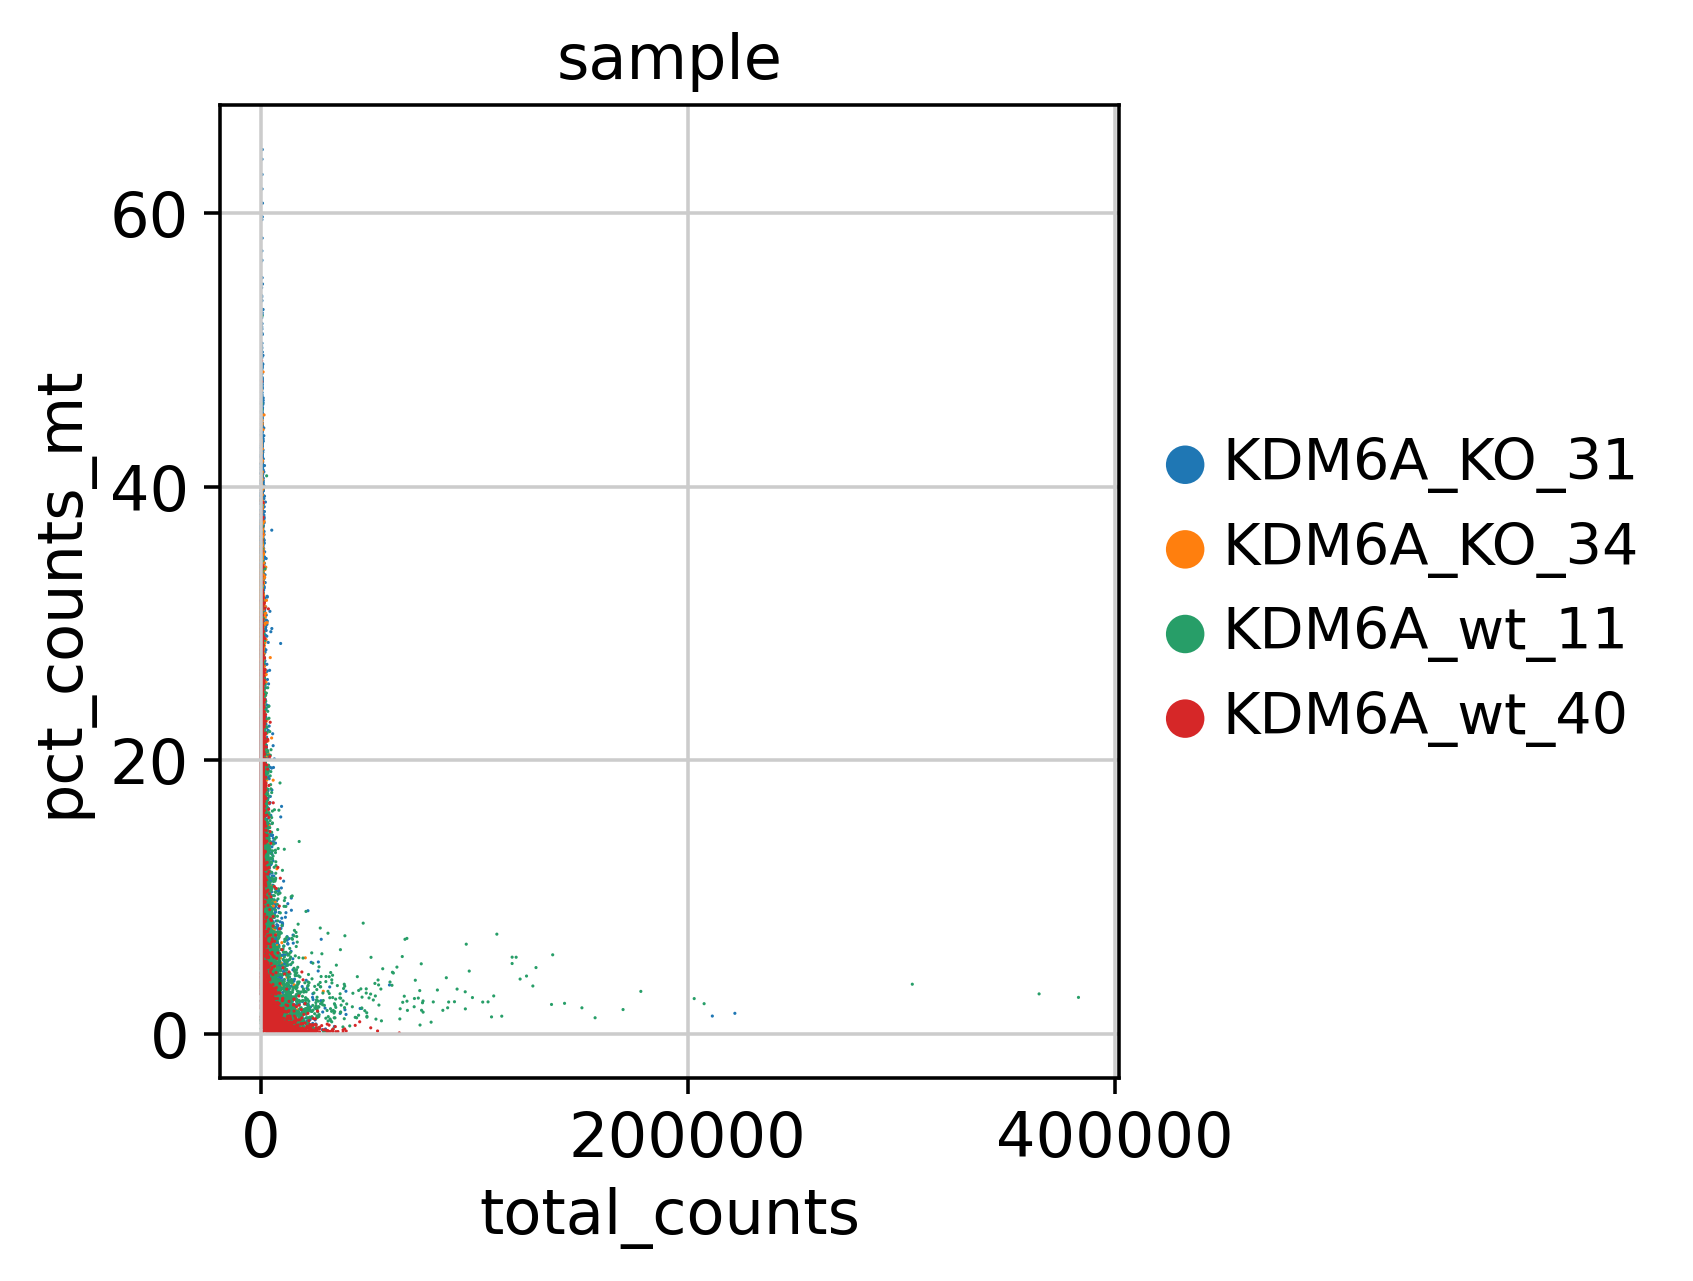

In [18]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "sample")

### Add sample sex covariate

In [19]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [20]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
mt-Tf,ENSMUSG00000064336,1,68,MT
mt-Rnr1,ENSMUSG00000064337,70,1024,MT
mt-Tv,ENSMUSG00000064338,1025,1093,MT
mt-Rnr2,ENSMUSG00000064339,1094,2675,MT
mt-Tl1,ENSMUSG00000064340,2676,2750,MT


In [22]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Gm29089', 'Zfy1', 'Uba1y', 'Gm28588', 'Gm28587', 'Kdm5d', 'Eif2s3y',
       'Gm29650', 'Uty', 'Ddx3y',
       ...
       'Gm28673', 'Gm28674', 'Gm21996', 'Gm28930', 'Gm29504', 'Gm20837',
       'Gm28300', 'Gm28301', 'Gm21860', 'Gm47283'],
      dtype='object', length=721)

In [23]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1) * 100

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


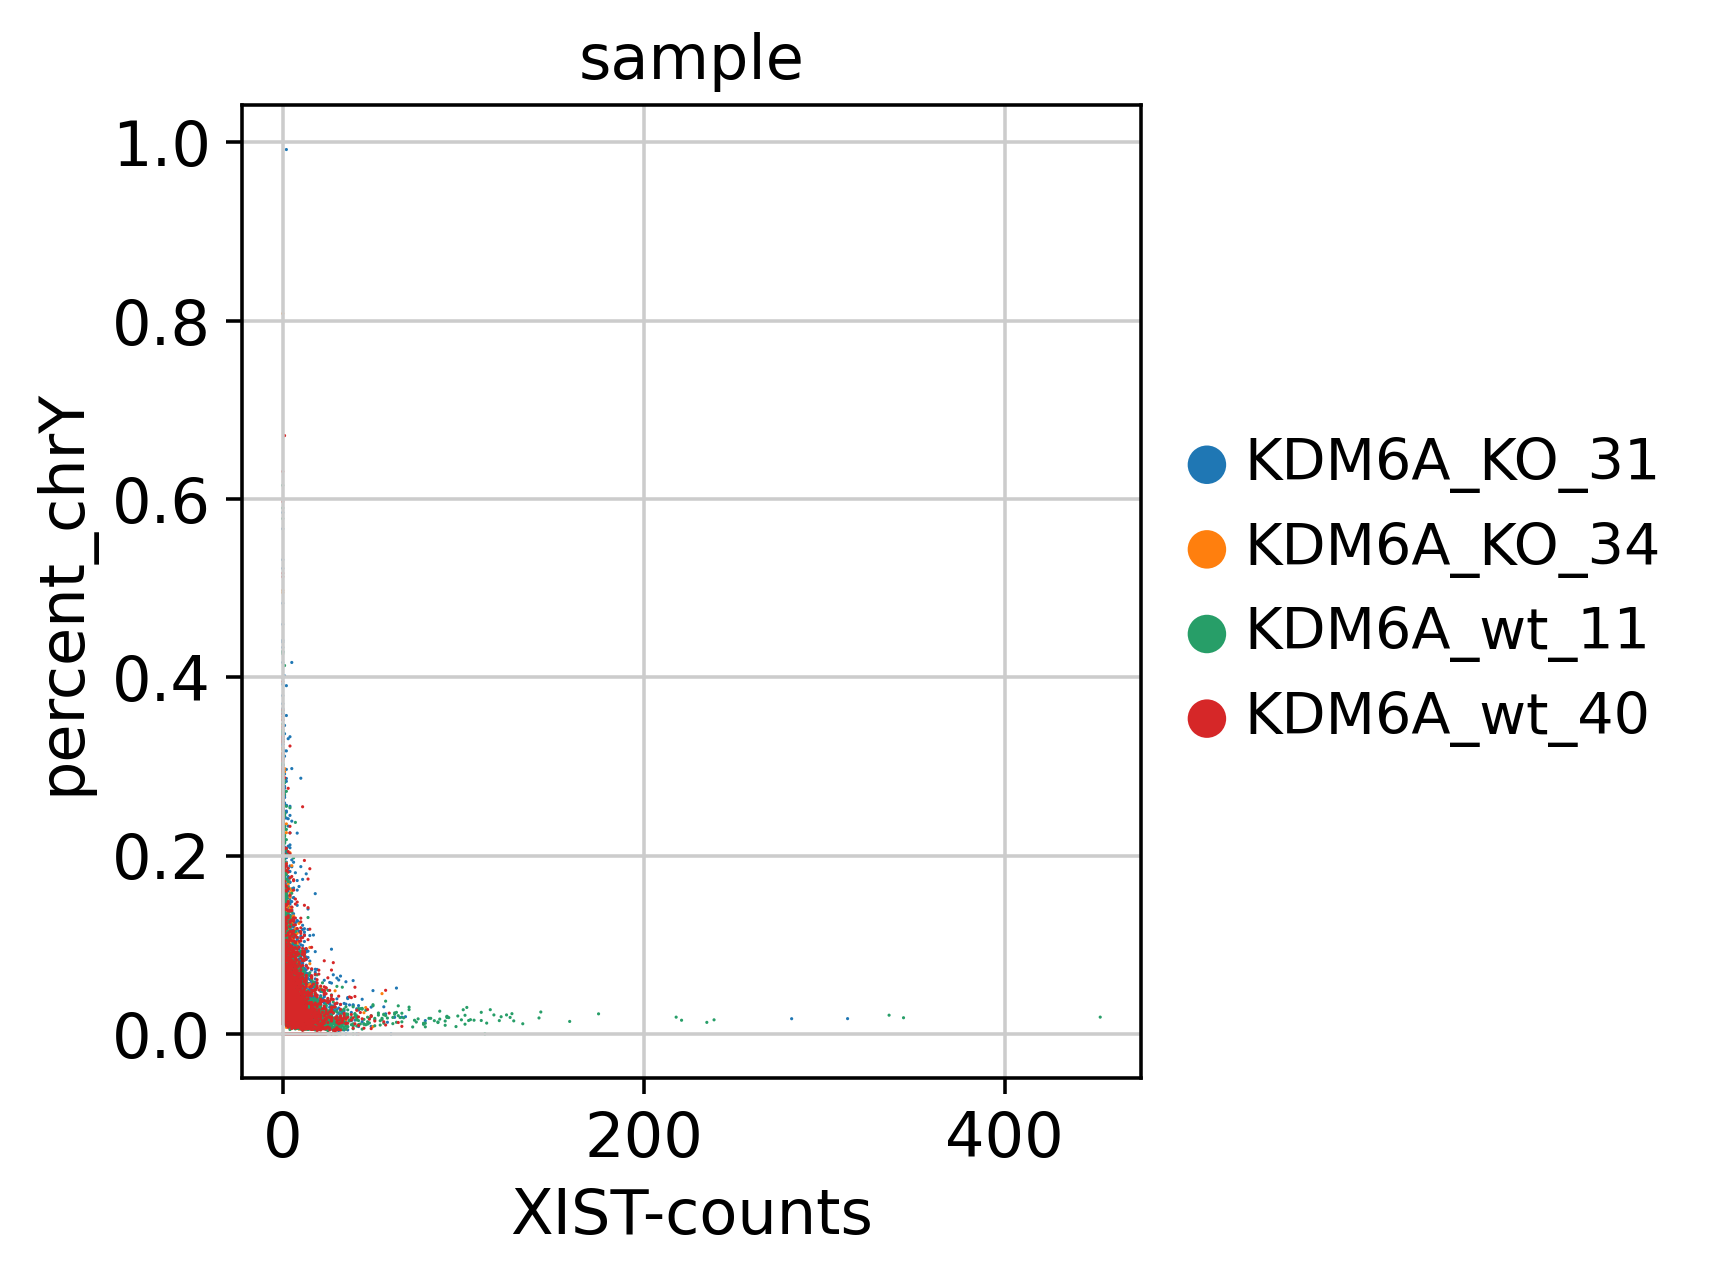

In [24]:
xist_counts = sample_object.X[:, sample_object.var_names.str.match('Xist')].toarray()
xist_counts_series = pd.Series(xist_counts.squeeze(), index = sample_object.obs_names, name = "XIST-counts")
sample_object.obs["XIST-counts"] = xist_counts_series

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "sample")

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

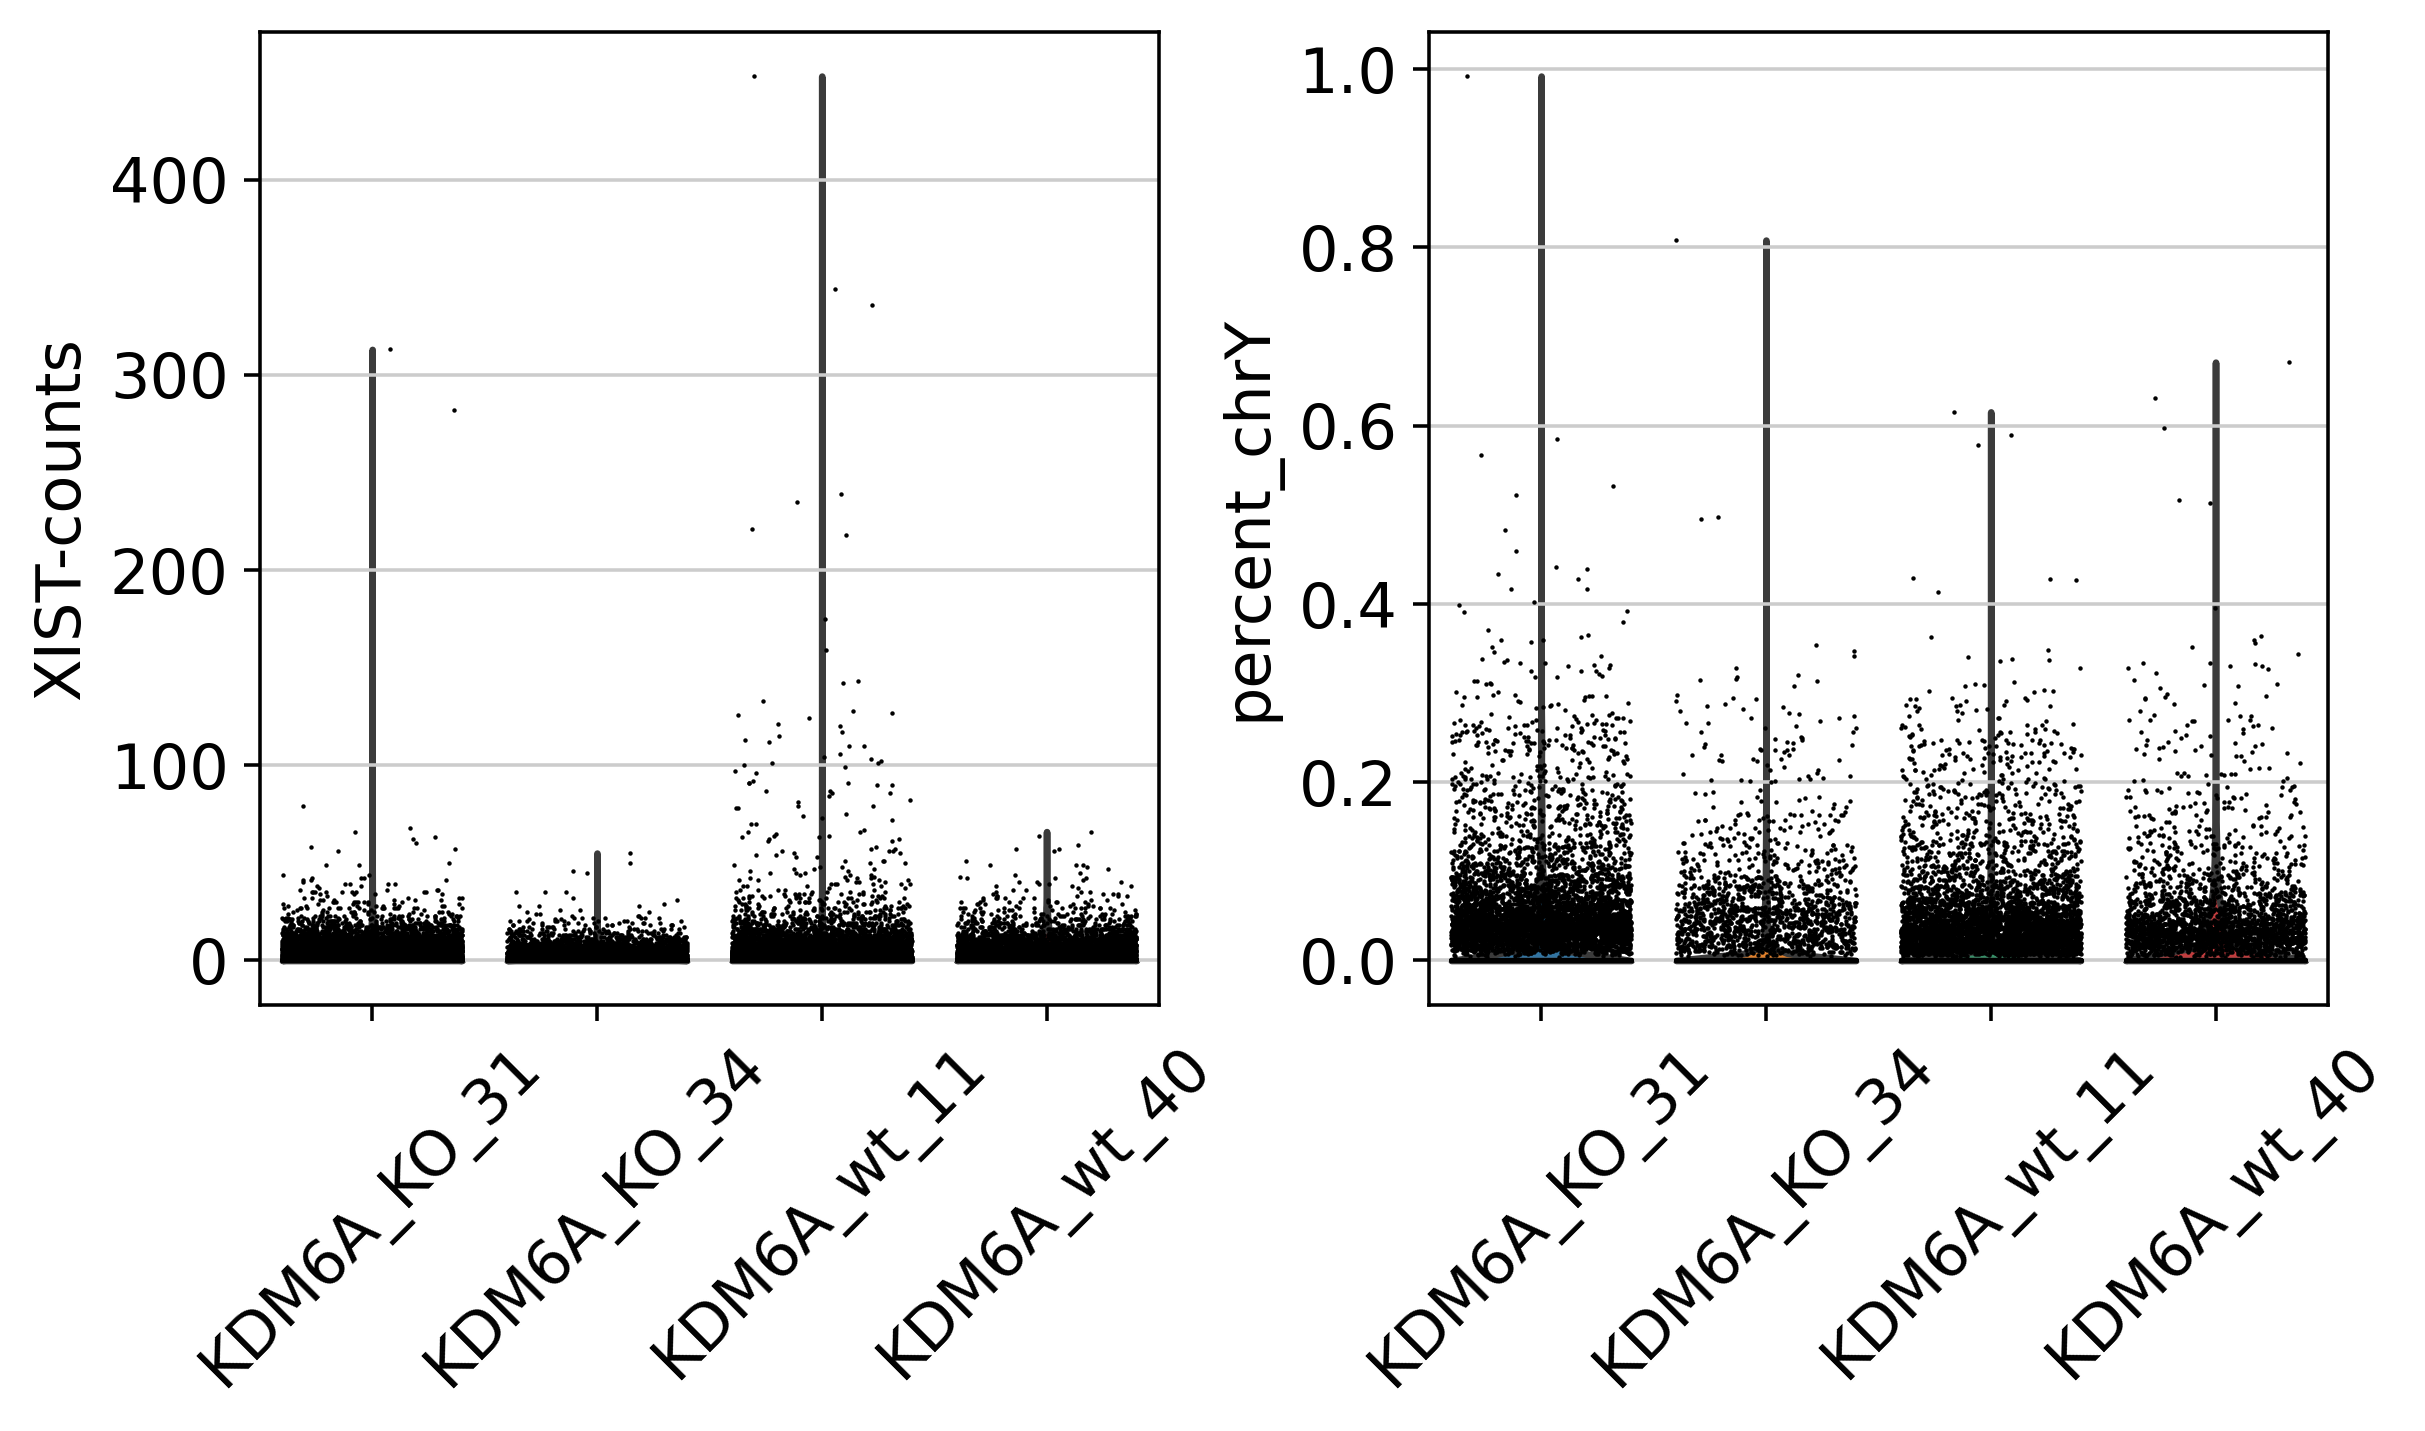

In [25]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'sample', rotation = 45)

### Calculate cell cycle scores

In [26]:
!if [ ! -f ../data/regev_lab_cell_cycle_genes.txt ]; then curl -o ../data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   556  100   556    0     0    900      0 --:--:-- --:--:-- --:--:--   899


In [27]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [28]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Fhl2', 'Camk1d', 'Cacnb2', 'Gsn', 'Xirp2', 'Ttn', 'Cst3', 'Pdlim5', 'Gm12381', 'Ccl21a', 'Ptprd', 'Nppa', 'Pcdh7', 'Kcnd2', 'Igkc', 'Cacna1c', 'Mgp', 'Hbb-bt', 'Hbb-bs', 'Csmd1', 'Dlc1', 'Palld', 'Ngp', 'Ctnna3', 'Hba-a1', 'Hba-a2', 'Igha', 'Ighg2b', 'Ighm', 'Ryr2', 'Pde4d', 'Ptprg', 'Myh6', 'Gpc6', 'Rbfox1', 'Zbtb20', 'Gm42418', 'AY036118', 'Slc8a1', 'Cd74', 'Malat1', 'Prkg1', 'Ankrd1', 'Fgf13', 'Dmd', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    513 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    558 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

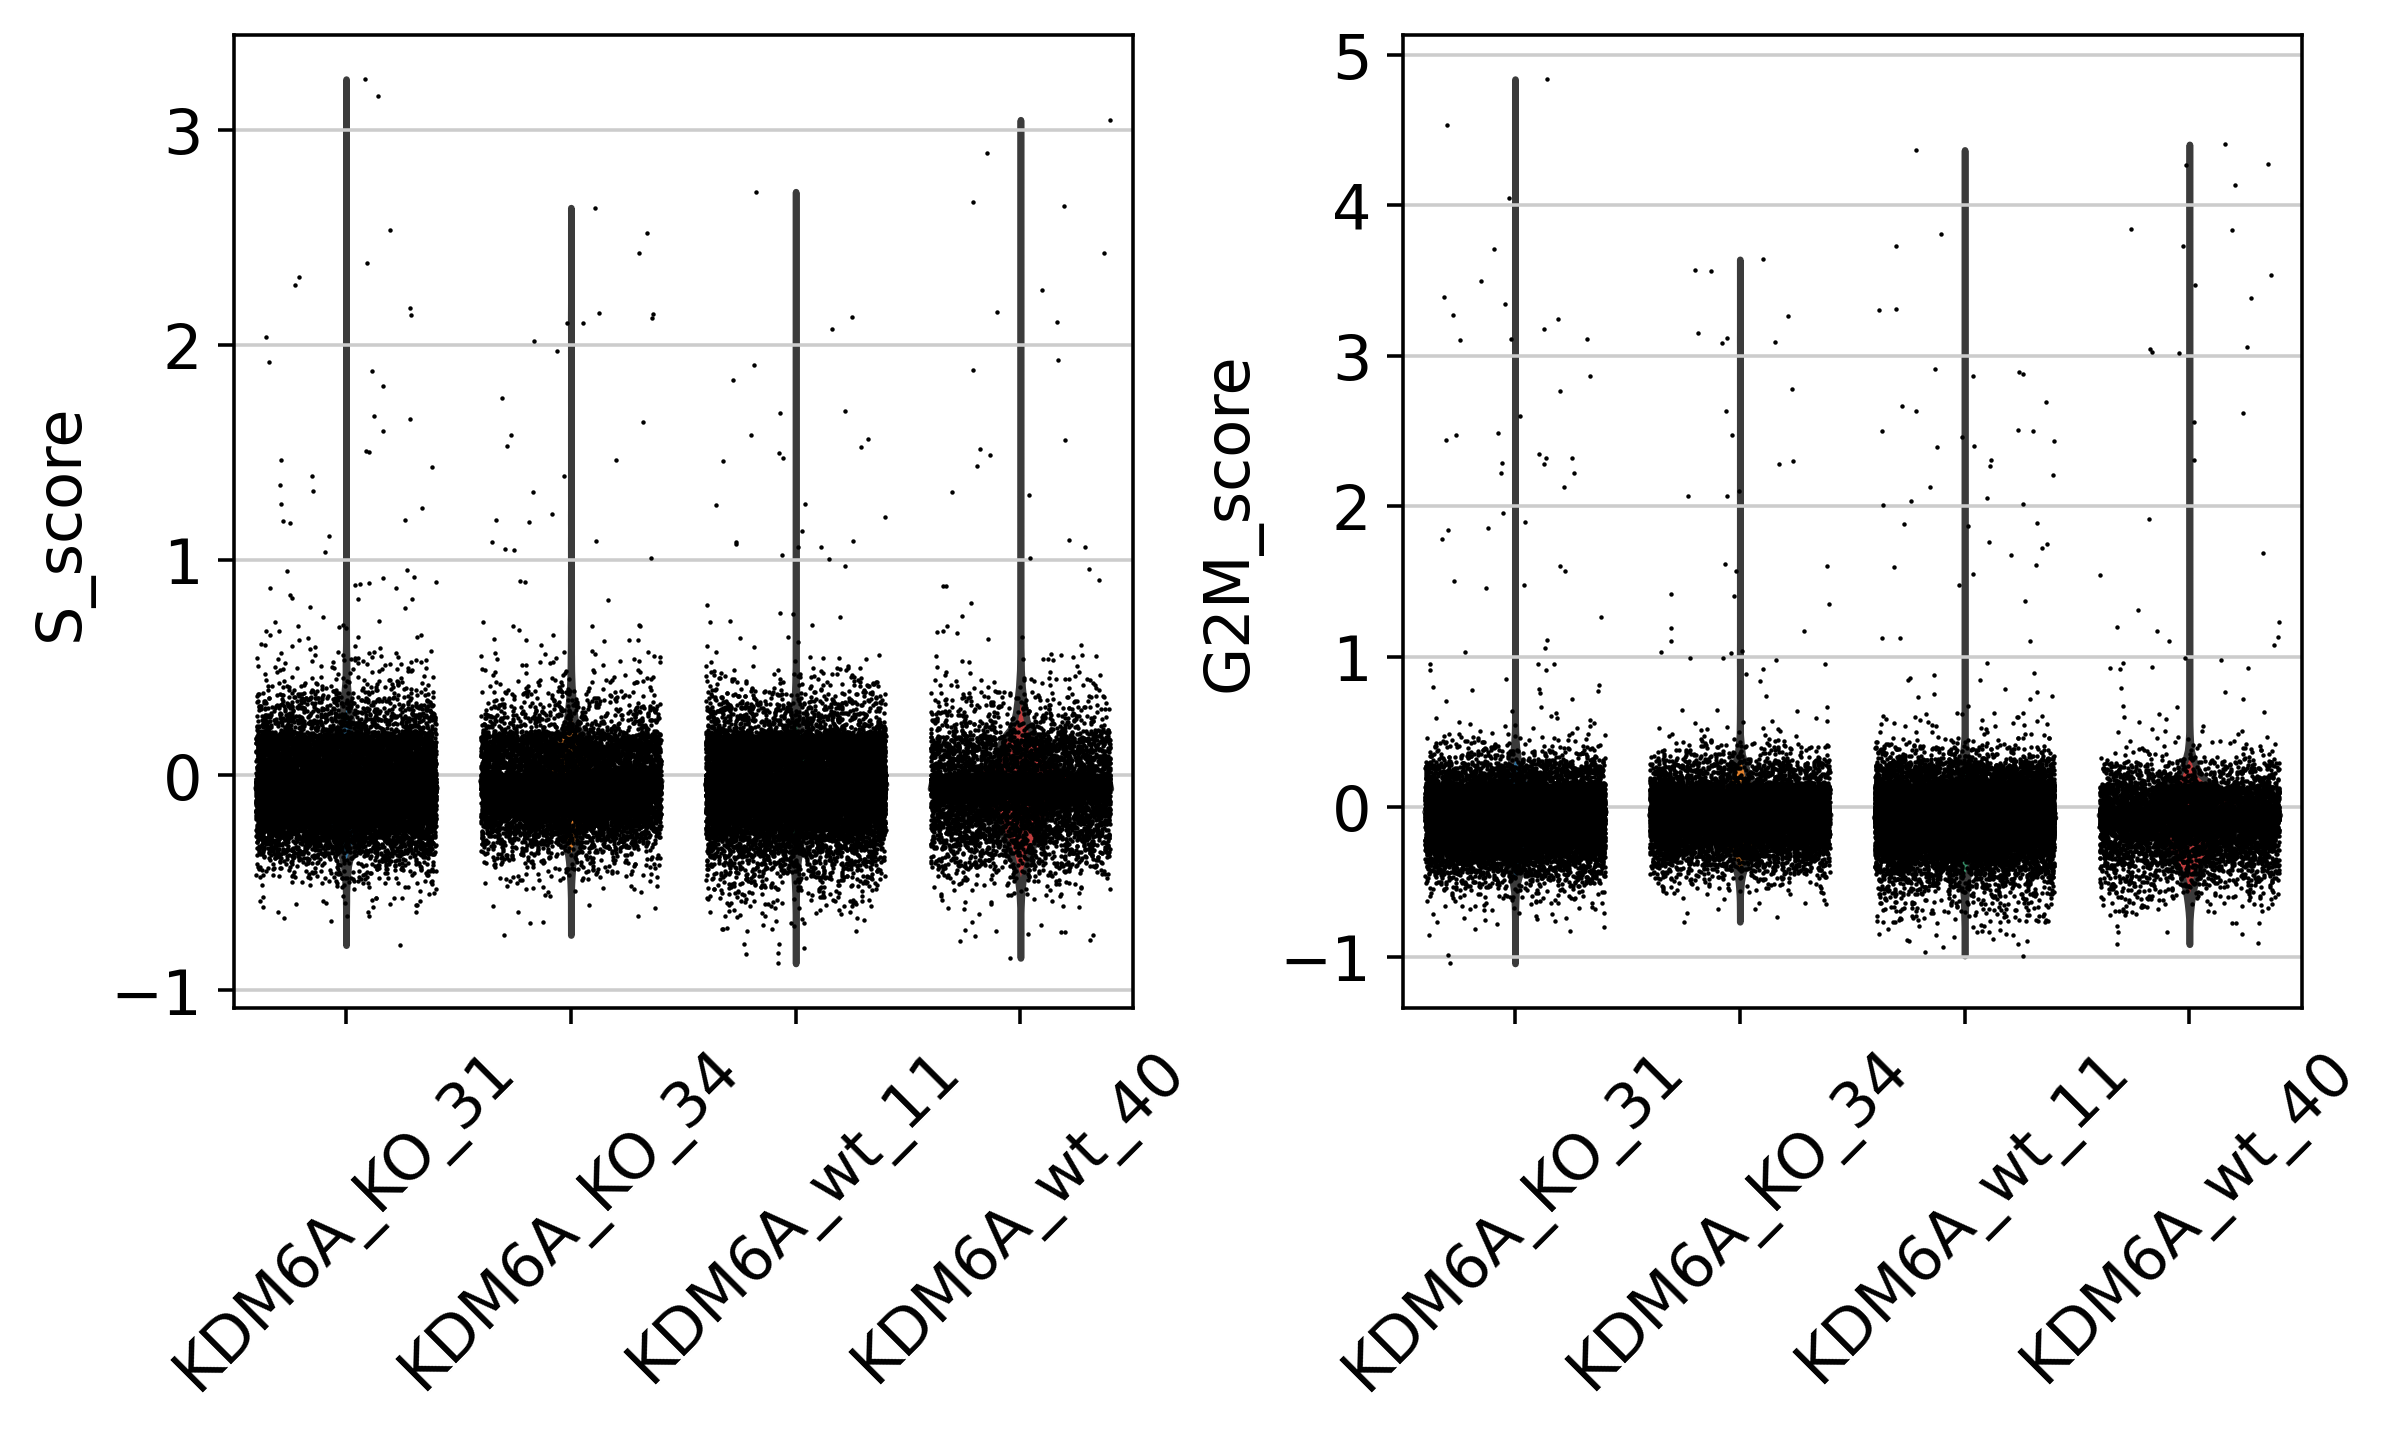

In [29]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'sample', rotation = 45)

In [30]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

AnnData object with n_obs × n_vars = 59933 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

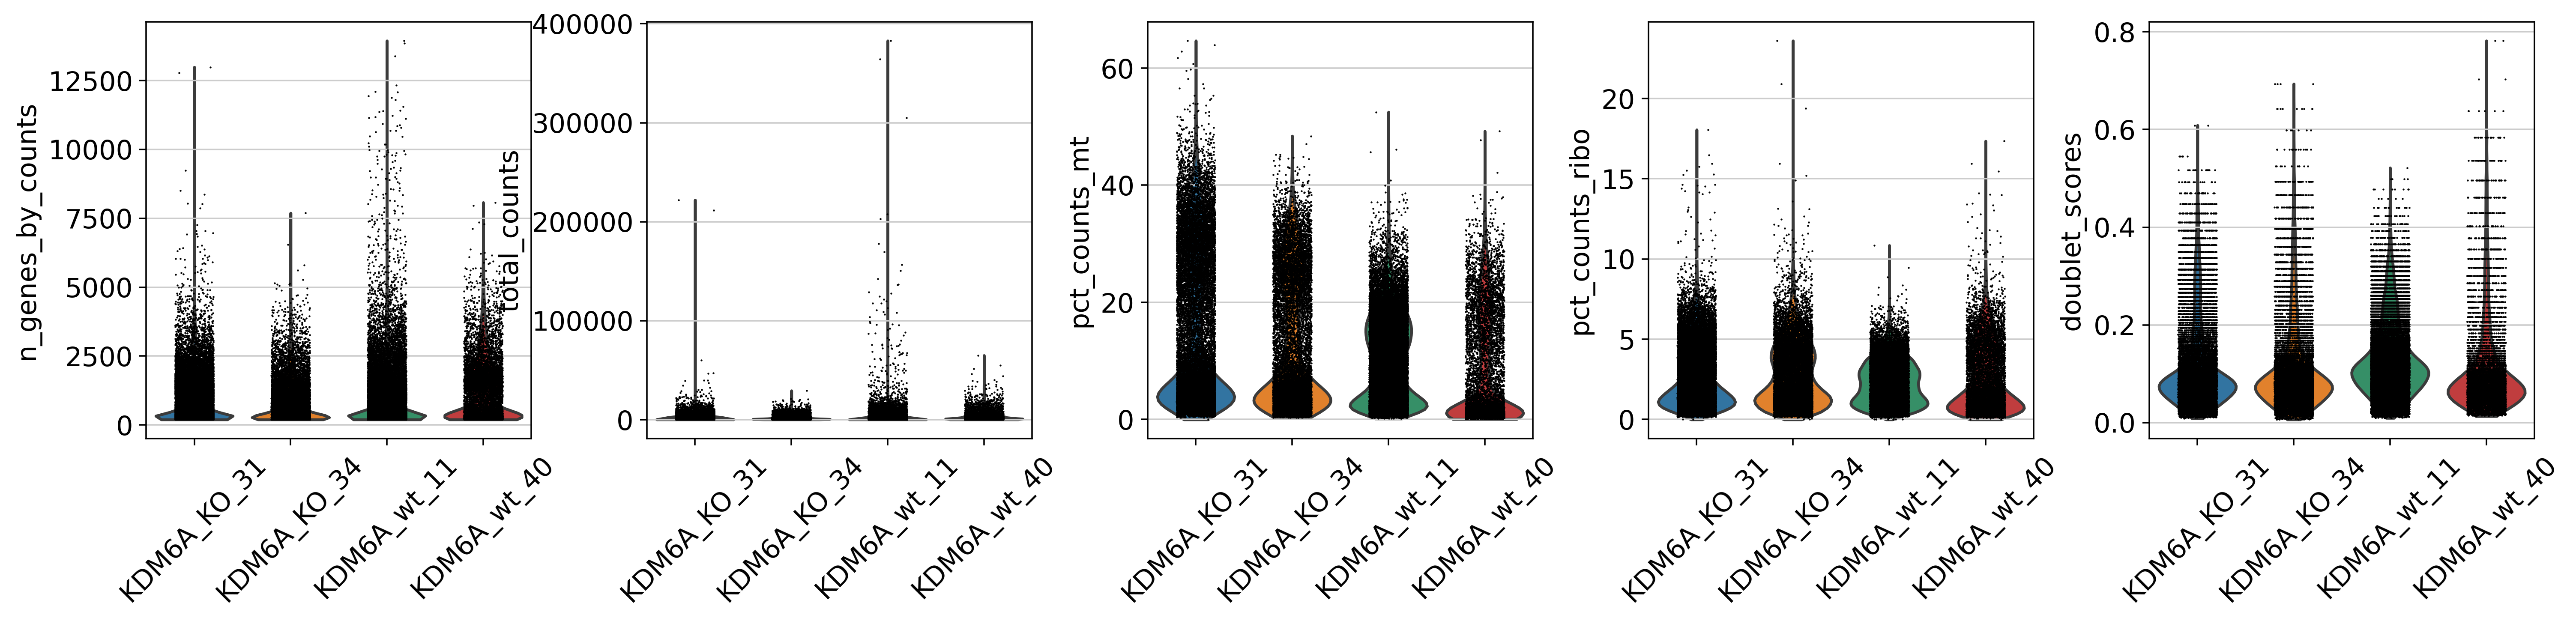

In [31]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'doublet_scores'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Prepare counts for individual slots

In [32]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 59933 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [33]:
del(sample_object.obs['predicted_doublets'])

### Export object

In [34]:
sample_object.write(path + 'Kdm6aKO_KDM6A_GEX_QCed_ctl240103.raw.h5ad')